In [27]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import numpy as np
np.random.seed(0)

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [5]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
print(np.linalg.inv(D + np.identity(4)) @ A)
print()
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


<BarContainer object of 37 artists>

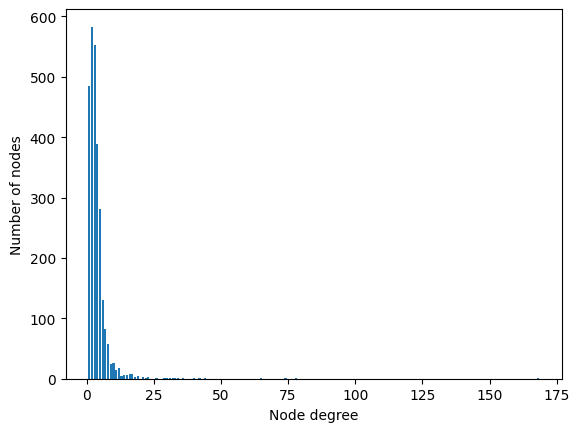

In [23]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

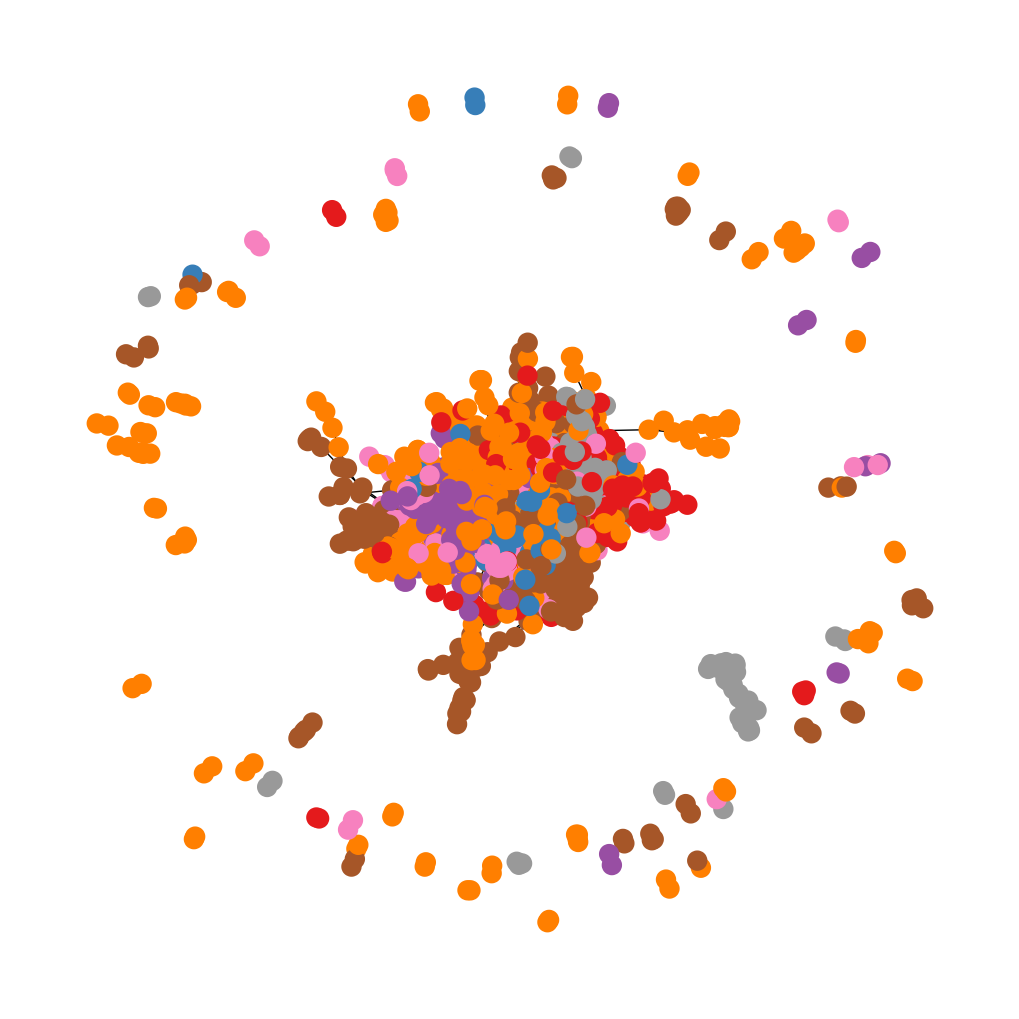

In [28]:
import torch
import torch_geometric
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx
import networkx as nx

plt.figure(figsize=(10, 10))
cora = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
g = torch_geometric.utils.to_networkx(cora, to_undirected=True)
coragraph = to_networkx(cora)
node_labels = data.y[list(coragraph.nodes)].numpy()
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)

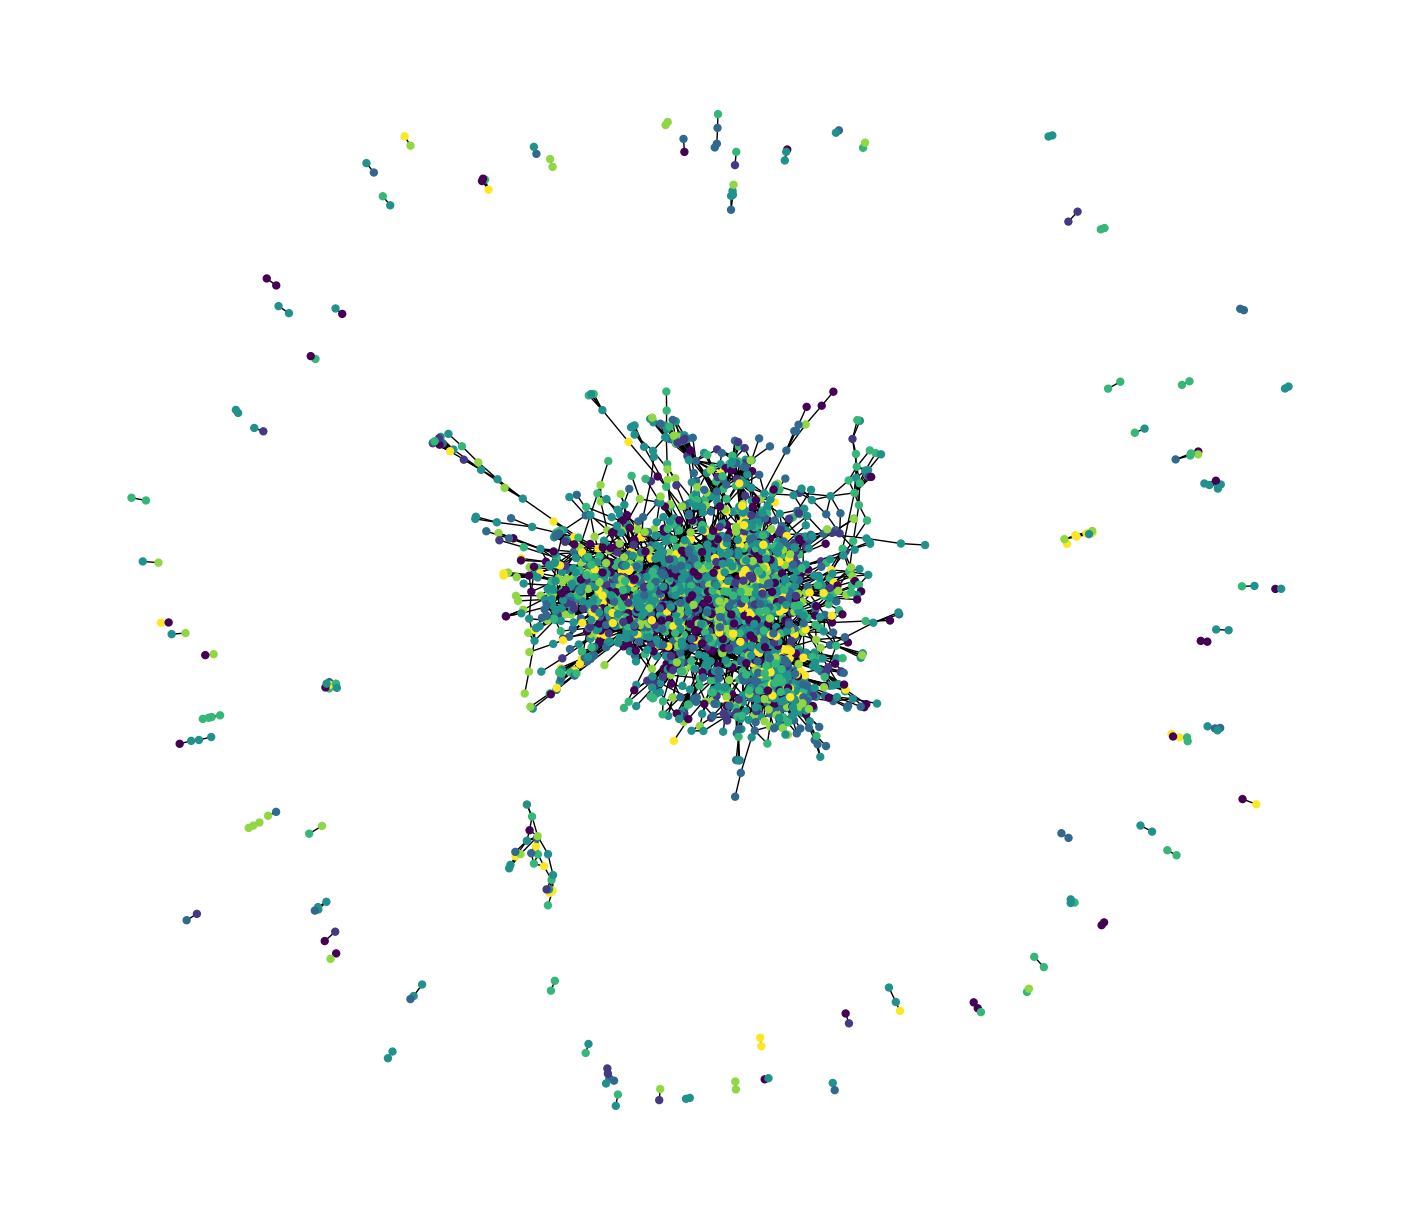

In [29]:
coragraph = to_networkx(data)

node_labels = data.y[list(coragraph.nodes)].numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(14,12))
nx.draw_spring(g, node_size=25, node_color=node_labels)

In [7]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



# Predicting web traffic with node regression

In [8]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T
dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


Done!


In [9]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

- We apply a log function to the target values using np.log10() because the goal is to predict the log average monthly traffic:

In [12]:
import pandas as pd

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<BarContainer object of 63 artists>

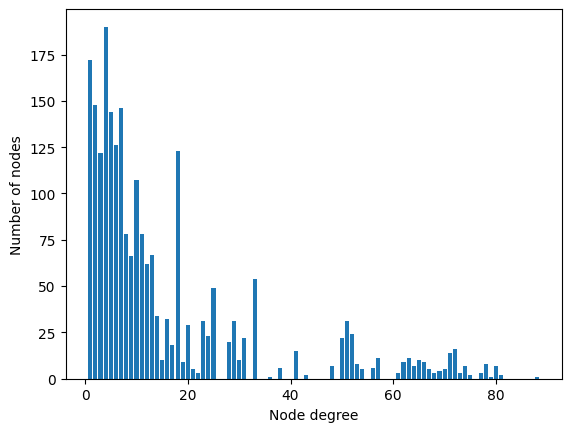

In [13]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 63 artists>

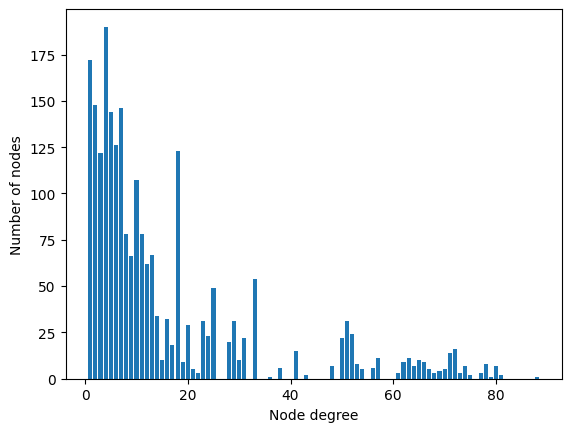

In [14]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<ipython-input-15-98934f87a9a2>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['target'], fit=norm)


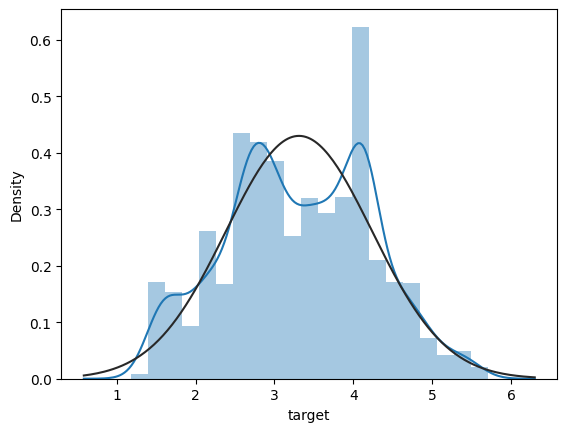

In [15]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

In [30]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Processing...
Done!


Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


<BarContainer object of 32 artists>

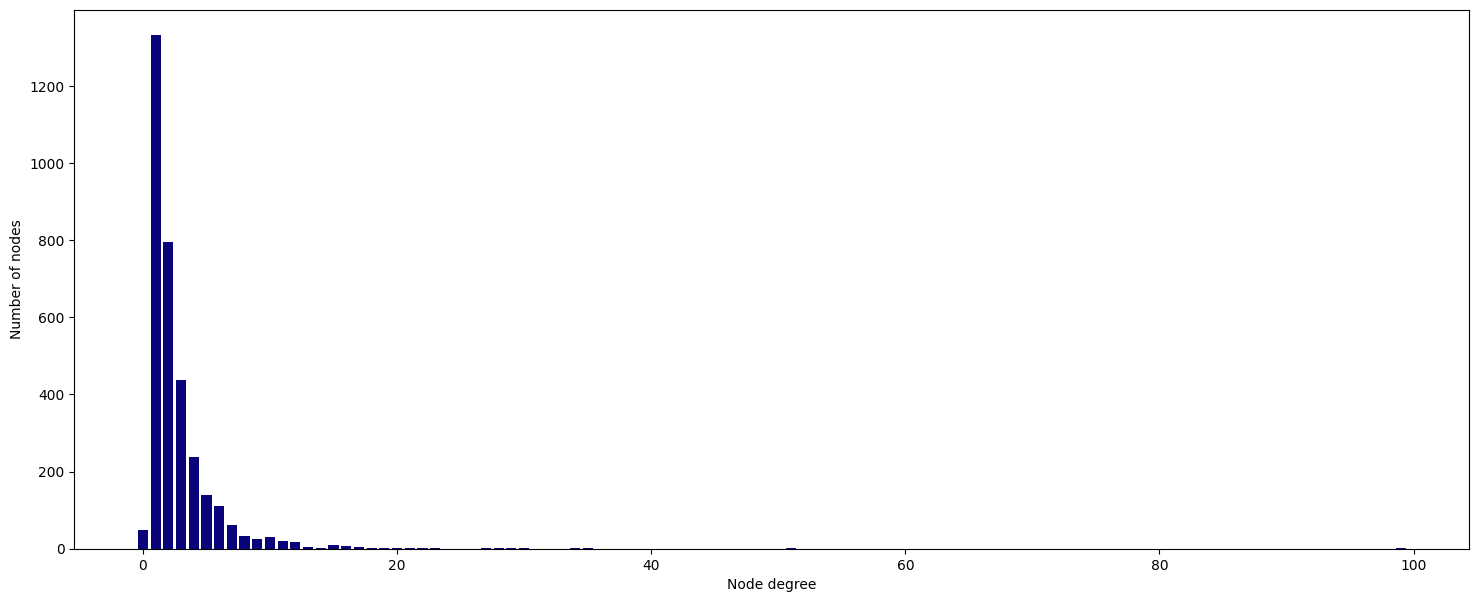

In [31]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

#II. Self-attention
Introduced by Veličković et al. in 2017, self-attention in GNNs relies on a simple idea: nodes should not all have the same importance.

We talk about self-attention (and not just attention) because inputs are compared to each other.

We could write a static formula, but there’s a smarter solution: we can learn their values with a neural network. There are three steps in this process:

- Linear transformation;
- Activation function;
- Softmax normalization.
- 1️⃣ Linear transformation
We want to calculate the importance of each connection, so we need pairs of hidden vectors. An easy way to create these pairs is to concatenate vectors from both nodes.

- 2️⃣ Activation function
We’re building a neural network, so the second step is to add an activation function. In this case, the authors of the paper chose the LeakyReLU function.

- 3️⃣ Softmax normalization
The output of our neural network is not normalized, which is a problem since we want to compare these scores. To be able to say if node 2 is more important to node 1 than node 3 (α₁₂ > α₁₃), we need to share the same scale.

A common way to do it with neural networks is to use the softmax function.

- 4️⃣ Bonus: multi-head attention
This is only slightly surprising since we’ve been talking about self-attention a lot but, in reality, transformers are GNNs in disguise. This is why we can reuse some ideas from Natural Language Processing here

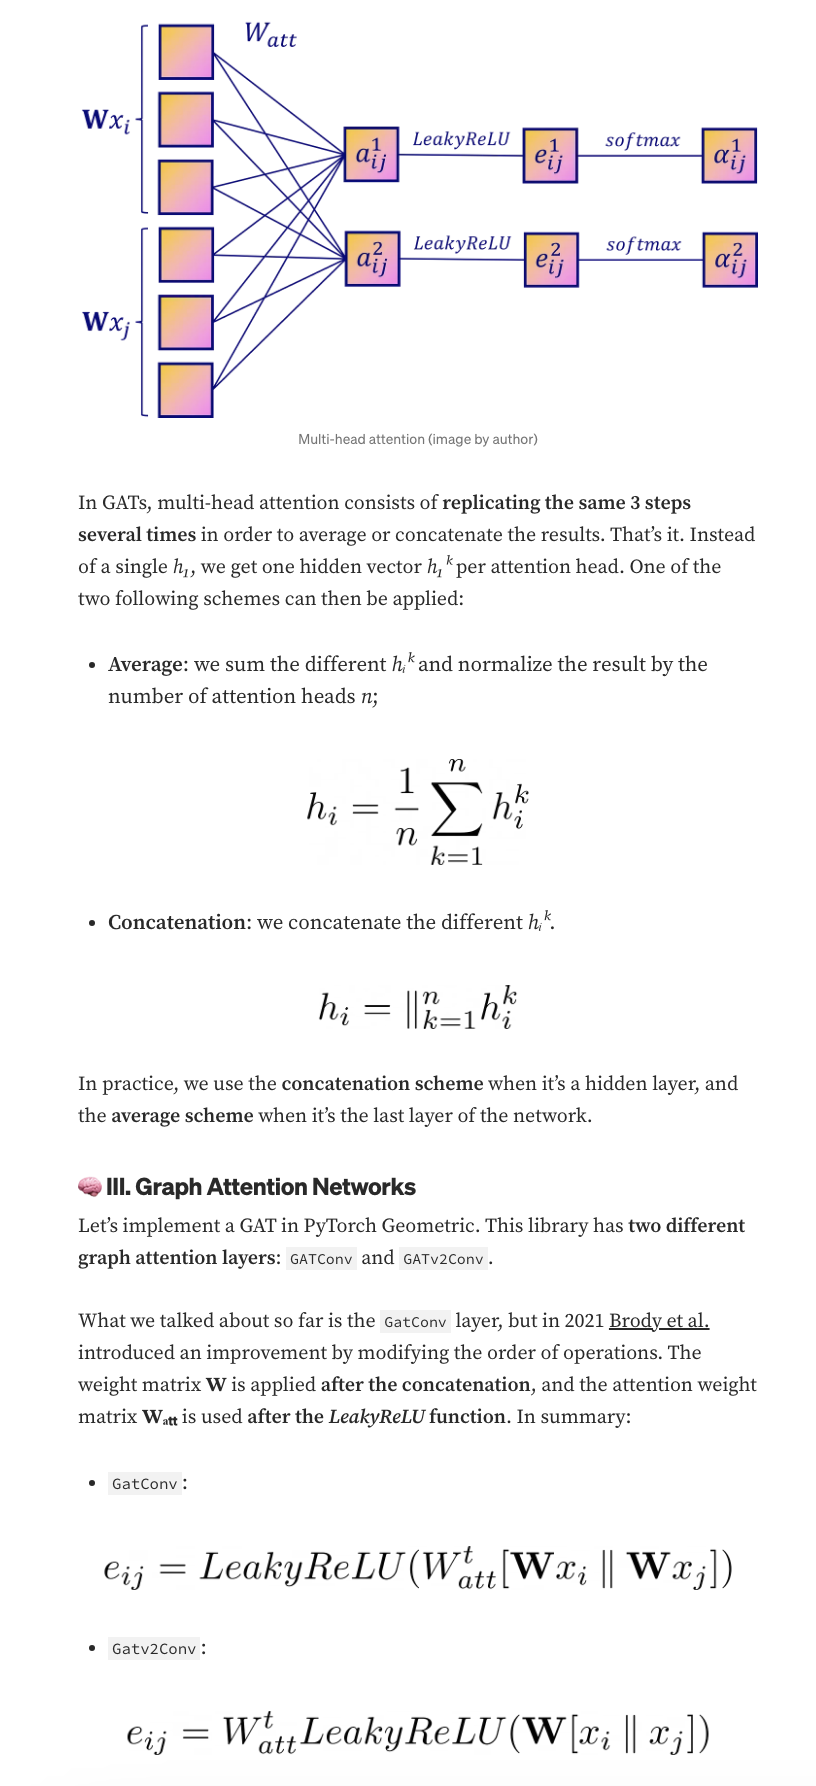

- 🧠 III. Graph Attention Networks
Let’s implement a GAT in PyTorch Geometric. This library has two different graph attention layers: GATConv and GATv2Conv.

In [32]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [33]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'GCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.796 | Train Acc:  15.00% | Val Loss: 1.80 | Val Acc: 14.80%
Epoch  10 | Train Loss: 0.517 | Train Acc:  94.17% | Val Loss: 1.31 | Val Acc: 56.20%
Epoch  20 | Train Loss: 0.200 | Train Acc:  96.67% | Val Loss: 1.52 | Val Acc: 51.60%
Epoch  30 | Train Loss: 0.124 | Train Acc:  94.17% | Val Loss: 1.43 | Val Acc: 57.40%
Epoch  40 | Train Loss: 0.071 | Train Acc:  99.17% | Val Loss: 1.66 | Val Acc: 56.00%
Epoch  50 | Train Loss: 0.056 | Train Acc: 100.00% | Val Loss: 1.66 | Val Acc: 55.00%
Epoch  60 | Train Loss: 0.065 | Train Acc:  98.33% | Val Loss: 1.62 | Val Acc: 56.40%
Epoch  70 | Train Loss: 0.065 | Train Acc:  98.33% | Val Loss: 1.50 | Val Acc: 61.80%
Epoch  80 | Train Loss: 0.056 | Train Acc:  97.50% | Val Loss: 1.62 | Val Acc: 58.20%
Epoch  90 | Train Loss: 0.047 | Train Acc:  99.17% | Val Loss: 1.65 | Val Acc: 55.60%
Epoch 100 | Train Loss: 0.043 | Train Acc:  99.17% | Val Loss: 1.67 | Val Acc: 5

In [34]:
%%time

# Create GAT
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'GAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.798 | Train Acc:  20.00% | Val Loss: 1.82 | Val Acc: 13.00%
Epoch  10 | Train Loss: 0.125 | Train Acc:  98.33% | Val Loss: 1.06 | Val Acc: 66.80%
Epoch  20 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 1.18 | Val Acc: 66.80%
Epoch  30 | Train Loss: 0.017 | Train Acc:  99.17% | Val Loss: 1.17 | Val Acc: 65.40%
Epoch  40 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.20 | Val Acc: 65.80%
Epoch  50 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.19 | Val Acc: 66.20%
Epoch  60 | Train Loss: 0.015 | Train Acc:  99.17% | Val Loss: 1.12 | Val Acc: 68.00%
Epoch  70 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.13 | Val Acc: 68.00%
Epoch  80 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 1.12 | Val Acc: 67.60%
Epoch  90 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 67.00%
Epoch 100 | Train Loss: 0.008 | Train Acc: 100.00% | Val Lo

This experiment is not super rigorous: we’d need to repeat it n times and take the average accuracy with a standard deviation as the final result.

We can see in this example that the GAT outperforms the GCN in terms of accuracy (70.00% vs. 67.70%), but takes longer to train (55.9s vs. 32.4s). It’s a tradeoff that can cause scalability issues when working with large graphs.

The authors obtained 72.5% for the GAT and 70.3% for the GCN, which is clearly better than what we did. The difference can be explained by preprocessing, some tweaks in the models, and a different training setting (e.g., a patience of 100 instead of a fixed number of epochs).

Let’s visualize what the GAT learned. We’re gonna use t-SNE, a powerful method to plot high-dimensional data in 2D or 3D. First, let’s see what the embeddings looked like before any training: it should be absolutely random since they’re produced by randomly initialized weight matrices.

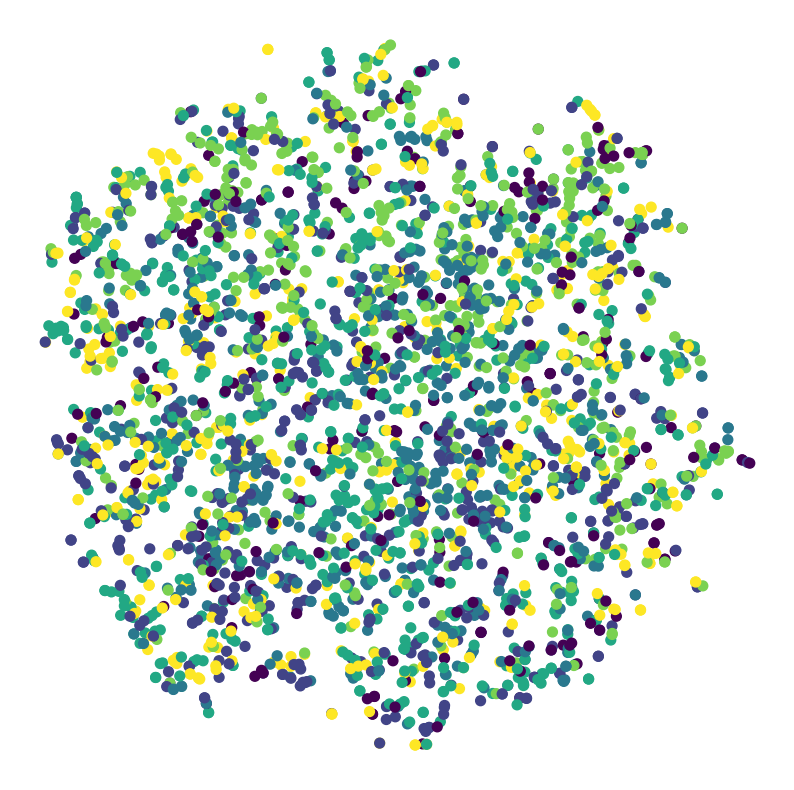

In [36]:
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

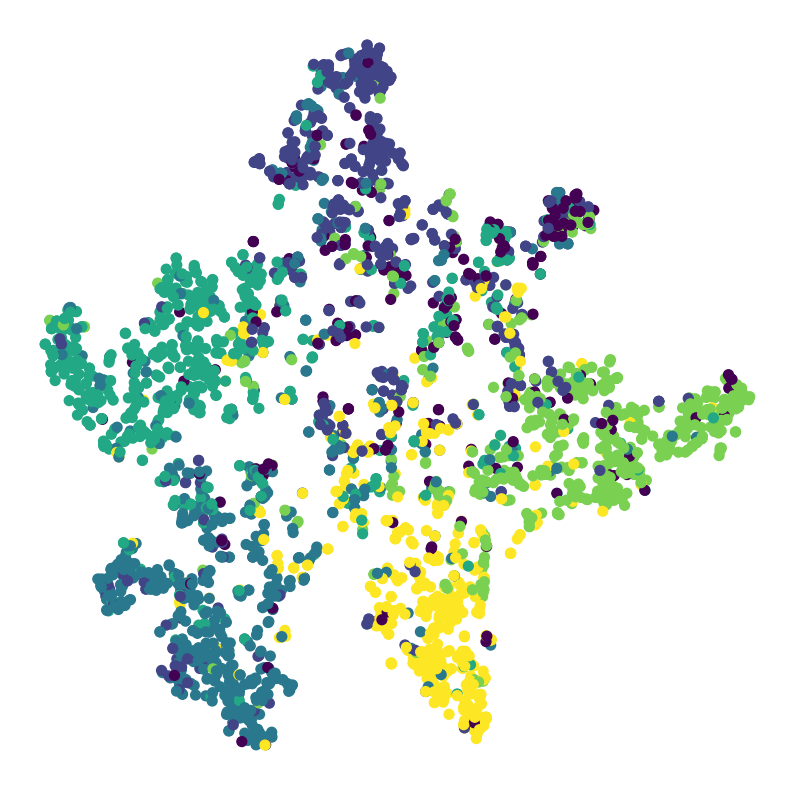

In [37]:
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

Previously, I speculated that poorly connected nodes might negatively impact performance on CiteSeer. Let’s calculate the model’s accuracy for each degree.

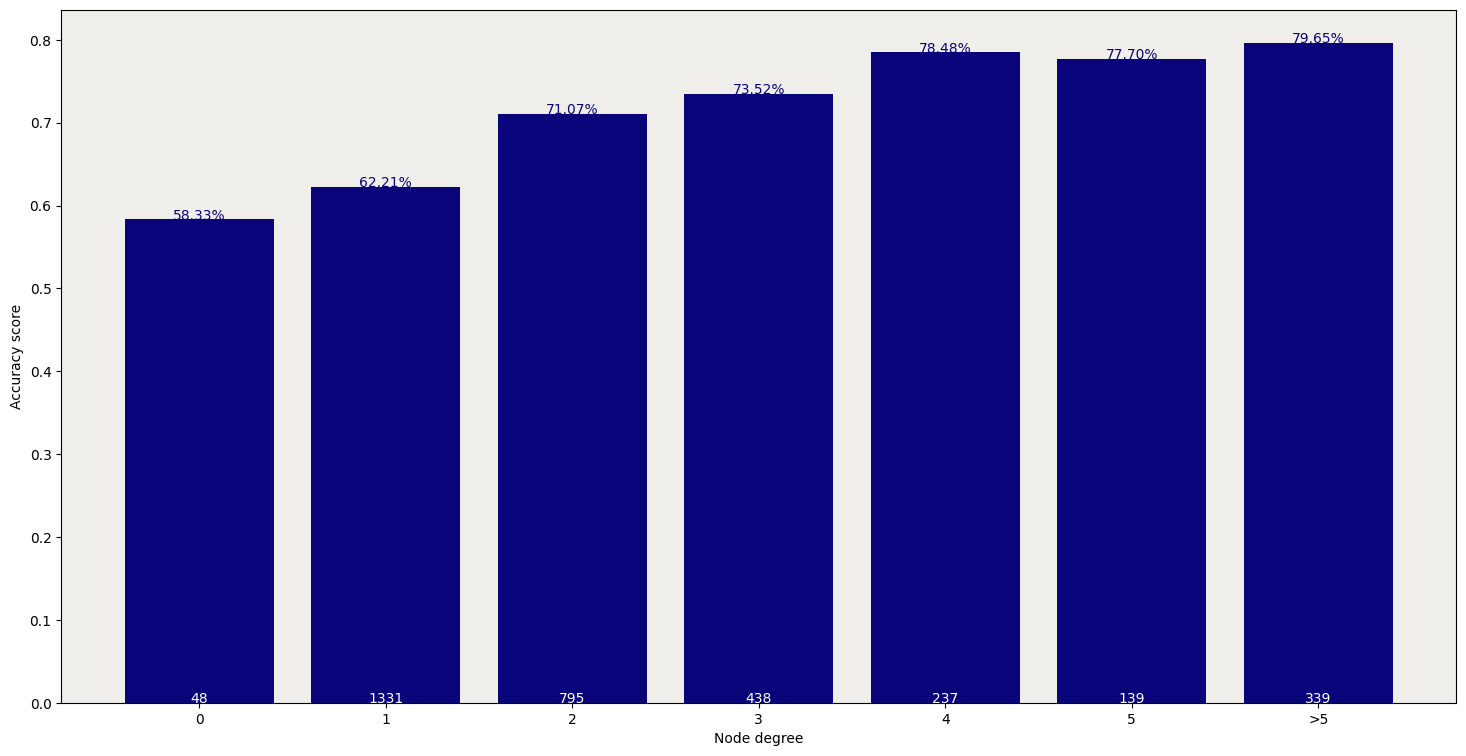

In [38]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_facecolor('#EFEEEA')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')